In [30]:
import fiasco
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import pwlf

In [19]:
temperature = np.logspace(4, 9, 101) * u.K
abundance_name = 'sun_photospheric_2009_asplund'
ioneq_name = 'chianti'
hdf5_dbase_root = fiasco.defaults['hdf5_dbase_root']
ion_kwargs = {
    'abundance': abundance_name,
    'ioneq_filename': ioneq_name,
    'hdf5_dbase_root': hdf5_dbase_root,
}
density = [1e10]*u.cm**-3


In [16]:
all_ions = [fiasco.Ion(i, temperature, **ion_kwargs) for i in fiasco.list_ions(hdf5_dbase_root)]
all_ions = fiasco.IonCollection(*all_ions)
all_ions2 = [fiasco.Ion(i, temperature, **ion_kwargs) for i in fiasco.list_ions(hdf5_dbase_root)]
all_ions2 = fiasco.IonCollection(*all_ions2)
all_ions3 = [fiasco.Ion(i, temperature, **ion_kwargs) for i in fiasco.list_ions(hdf5_dbase_root)]
all_ions3 = fiasco.IonCollection(*all_ions3)
all_ions4 = [fiasco.Ion(i, temperature, **ion_kwargs) for i in fiasco.list_ions(hdf5_dbase_root)]
all_ions4 = fiasco.IonCollection(*all_ions4)

for i in range(len(all_ions)):
    name = all_ions[i].element_name
    neutral = fiasco.Ion(name+' I', 1e6*u.K)
    if( neutral.ionization_potential.to(u.eV) < 10.0*u.eV):
        all_ions2[i].abundance = 2.0 * all_ions[i].abundance
        all_ions3[i].abundance = 3.0 * all_ions[i].abundance
        all_ions4[i].abundance = 4.0 * all_ions[i].abundance


In [18]:
print(all_ions[100].abundance)
print(all_ions2[100].abundance)
print(all_ions3[100].abundance)
print(all_ions4[100].abundance)

2.818382931264455e-06
5.63676586252891e-06
8.455148793793365e-06
1.127353172505782e-05


In [20]:
# This'll be slow
rl = all_ions.radiative_loss(density)
rl2 = all_ions2.radiative_loss(density)
rl3 = all_ions3.radiative_loss(density)
rl4 = all_ions4.radiative_loss(density)

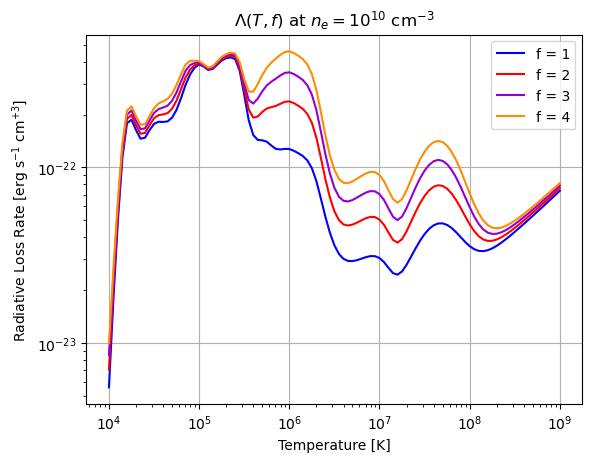

In [28]:
plt.plot(temperature, rl, label='f = 1', color='blue')
plt.plot(temperature, rl2, label='f = 2', color='red',)
plt.plot(temperature, rl3, label='f = 3', color='darkviolet')
plt.plot(temperature, rl4, label='f = 4', color='darkorange')
plt.legend()
plt.grid('-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Radiative Loss Rate [erg s$^{-1}$ cm$^{+3}$]')
plt.title('$\Lambda(T, f)$ at $n_{e} = 10^{10}$ cm$^{-3}$')
plt.savefig('loss_rate.png', dpi=300)

In [61]:
model4 = pwlf.PiecewiseLinFit(np.log10(temperature.value), np.log10(rl4[:,0].value))

# Set the number of breakpoints (e.g., 3)
breakpoints = 11
model4.fit(breakpoints)

# Generate the fitted y-values
y4 = model4.predict(np.log10(temperature.value))

shared_breaks = model4.fit_breaks

In [64]:
# Fit other datasets with same breakpoints
model1 = pwlf.PiecewiseLinFit(np.log10(temperature.value), np.log10(rl[:,0].value))
model2 = pwlf.PiecewiseLinFit(np.log10(temperature.value), np.log10(rl2[:,0].value))
model3 = pwlf.PiecewiseLinFit(np.log10(temperature.value), np.log10(rl3[:,0].value))

model1.fit_with_breaks(shared_breaks)
model2.fit_with_breaks(shared_breaks)
model3.fit_with_breaks(shared_breaks)

y1 = model1.predict(np.log10(temperature.value))
y2 = model2.predict(np.log10(temperature.value))
y3 = model3.predict(np.log10(temperature.value))

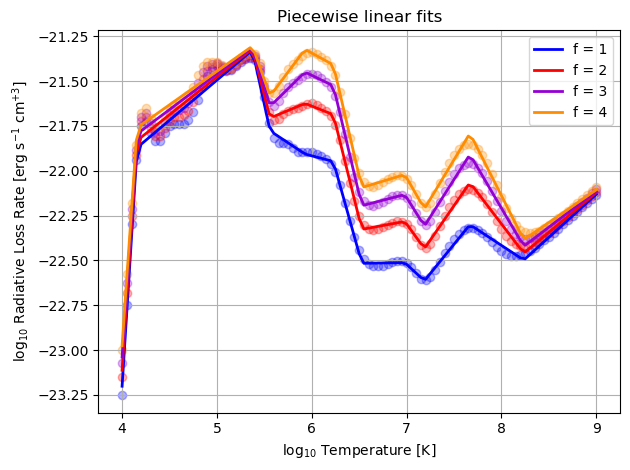

In [111]:
plt.scatter(np.log10(temperature.value), np.log10(rl[:,0].value), color='blue', alpha=0.3)
plt.plot(np.log10(temperature.value), y1, label='f = 1', color='blue', linewidth=2)

plt.scatter(np.log10(temperature.value), np.log10(rl2[:,0].value), color='red', alpha=0.3)
plt.plot(np.log10(temperature.value), y2, label='f = 2', color='red', linewidth=2)

plt.scatter(np.log10(temperature.value), np.log10(rl3[:,0].value), color='darkviolet', alpha=0.3)
plt.plot(np.log10(temperature.value), y3, label='f = 3', color='darkviolet', linewidth=2)

plt.scatter(np.log10(temperature.value), np.log10(rl4[:,0].value), color='darkorange', alpha=0.3)
plt.plot(np.log10(temperature.value), y4, label='f = 4', color='darkorange', linewidth=2)

plt.grid('-')
plt.legend()
plt.xlabel('log$_{10}$ Temperature [K]')
plt.ylabel('log$_{10}$ Radiative Loss Rate [erg s$^{-1}$ cm$^{+3}$]')
plt.title('Piecewise linear fits')
plt.tight_layout()
plt.savefig('fitted_loss_rate.png', dpi=300)

In [107]:
import pandas as pd

models = [model1, model2, model3, model4]
labels = ['f = 1', 'f = 2', 'f = 3', 'f = 4']

rows = []

labels = ('Temperature Range', 
           r'$\alpha(f = 1)$', r'$\chi(f = 1)$', 
           r'$\alpha(f = 2)$', r'$\chi(f = 2)$',
           r'$\alpha(f = 3)$', r'$\chi(f = 3)$',
           r'$\alpha(f = 4)$', r'$\chi(f = 4)$',
         )

for i in range(len(model.slopes)):
    rows.append({
        labels[0]: f"{breaks[i]:.2f} $\leq \log T \leq$ {breaks[i+1]:.2f}",
        labels[1]: f"{model1.slopes[i]:.2f}",
        labels[2]: f"{10.0**(model1.intercepts[i]):.2e}",
        labels[3]: f"{model2.slopes[i]:.2f}",
        labels[4]: f"{10.0**(model2.intercepts[i]):.2e}",
        labels[5]: f"{model3.slopes[i]:.2f}",
        labels[6]: f"{10.0**(model3.intercepts[i]):.2e}",
        labels[7]: f"{model4.slopes[i]:.2f}",
        labels[8]: f"{10.0**(model4.intercepts[i]):.2e}",
    })

# Convert to DataFrame
df = pd.DataFrame(rows)
print(df)

               Temperature Range $\alpha(f = 1)$ $\chi(f = 1)$  \
0   4.00 $\leq \log T \leq$ 4.16            8.36      2.22e-57   
1   4.16 $\leq \log T \leq$ 5.37            0.45      1.85e-24   
2   5.37 $\leq \log T \leq$ 5.56           -2.42      4.60e-09   
3   5.56 $\leq \log T \leq$ 5.93           -0.35      1.50e-20   
4   5.93 $\leq \log T \leq$ 6.23           -0.14      8.14e-22   
5   6.23 $\leq \log T \leq$ 6.53           -1.89      6.58e-11   
6   6.53 $\leq \log T \leq$ 6.98            0.01      2.68e-23   
7   6.98 $\leq \log T \leq$ 7.19           -0.49      7.97e-20   
8   7.19 $\leq \log T \leq$ 7.67            0.65      5.00e-28   
9   7.67 $\leq \log T \leq$ 8.24           -0.35      2.29e-20   
10  8.24 $\leq \log T \leq$ 9.00            0.48      3.50e-27   

   $\alpha(f = 2)$ $\chi(f = 2)$ $\alpha(f = 3)$ $\chi(f = 3)$  \
0             8.05      4.77e-56            7.82      4.68e-55   
1             0.42      2.61e-24            0.40      3.59e-24   
2        

In [109]:
latex_table = df.to_latex(index=False, column_format="lcccccccc", escape=False)
with open("piecewise_table.tex", "w") as f:
    f.write(latex_table)